In [38]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import trange, tqdm
import jax
import optax
import matplotlib.pyplot as plt
import importlib
from pathlib import Path

# Force reload of project files
import data, train, models, evaluate, metrics
importlib.reload(data)
from data import DataLoader

data_dir = Path("../data/wqp")
basin_list_file = data_dir / "metadata" / "site_lists" / "sites_flux_area1000_n10.txt"

sequence_length = 30
batch_size = 512

with open(basin_list_file, 'r') as file:
    basin_list = file.readlines()
    basin_list = [basin.strip() for basin in basin_list]

data_params = {'data_dir': data_dir,
               'basins': basin_list,
               'features_dict': {'daily':['grfr_q'],
                                 'irregular':['Blue','Green','Red','Nir','Swir1','Swir2']},
               'target': 'flux',
               'time_slice': slice('1979-01-01', '2018-12-31'),
               'split_time': np.datetime64('2010-01-01'),
               'batch_size': batch_size,
               'sequence_length': sequence_length,
               'discharge_col': 'grfr_q'}

dataloader = DataLoader(**data_params)

Batch loading set to 1 cpu(s)


Loading Basins:   0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
importlib.reload(models)
importlib.reload(train)
from models import TAPLSTM, EALSTM, LSTM
from train import start_training


daily_in_size = len(data_params['features_dict']['daily'])
irregular_in_size = len(data_params['features_dict']['irregular'])
static_in_size = dataloader.x_s[basin_list[0]].shape[0]
output_size = 1
hidden_size = 64
dropout = 0.4
key = jax.random.PRNGKey(0)

num_epochs =  250
# lr_schedule = optax.polynomial_schedule(0.01, 0.0001, 2, num_epochs)
lr_schedule = optax.exponential_decay(0.005, num_epochs, 0.5)

model = TAPLSTM(daily_in_size, irregular_in_size, static_in_size, output_size, hidden_size, key=key, dropout=dropout)
# model = LSTM(daily_in_size, output_size, hidden_size, key=key, dropout=dropout)
# model = EALSTM(daily_in_size, static_in_size, output_size, hidden_size, key=key, dropout=dropout)

model = start_training(model, dataloader, lr_schedule, num_epochs)


Epoch:1 LR:0.0050:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:2 LR:0.0050:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:3 LR:0.0050:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:4 LR:0.0049:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:5 LR:0.0049:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:6 LR:0.0049:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:7 LR:0.0049:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:8 LR:0.0049:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:9 LR:0.0049:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:10 LR:0.0049:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:11 LR:0.0048:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:12 LR:0.0048:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:13 LR:0.0048:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:14 LR:0.0048:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:15 LR:0.0048:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:16 LR:0.0048:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:17 LR:0.0048:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:18 LR:0.0048:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:19 LR:0.0047:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:20 LR:0.0047:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:21 LR:0.0047:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:22 LR:0.0047:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:23 LR:0.0047:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:24 LR:0.0047:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch:25 LR:0.0047:   0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/726 [00:00<?, ?it/s]

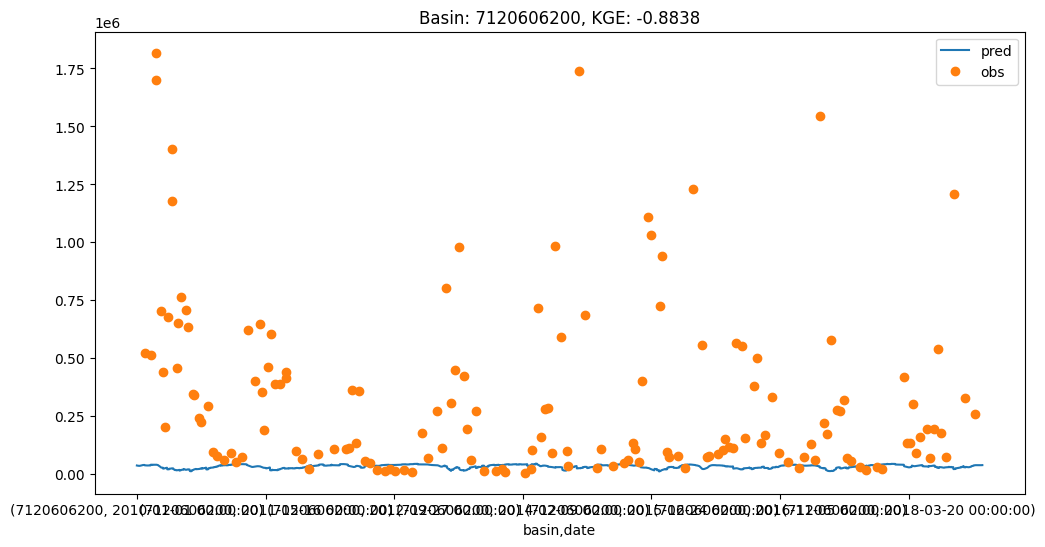

In [21]:
from metrics import get_all_metrics
from matplotlib.dates import YearLocator, DateFormatter
import datetime 

importlib.reload(evaluate)
from evaluate import predict

basin_subset = np.random.choice(basin_list).tolist()
results = predict(model, dataloader, basin_subset=basin_subset)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0
metrics = get_all_metrics(results['obs'],results['pred'])

# Plot the true values and predictions
fig, ax = plt.subplots(figsize=(12, 6))
results['pred'].plot(ax=ax)
results['obs'].plot(ax=ax,linestyle='None',marker='o')

plt.title(f"Basin: {basin_subset}, KGE: {metrics['kge']:0.4f}")
plt.legend()
plt.show()

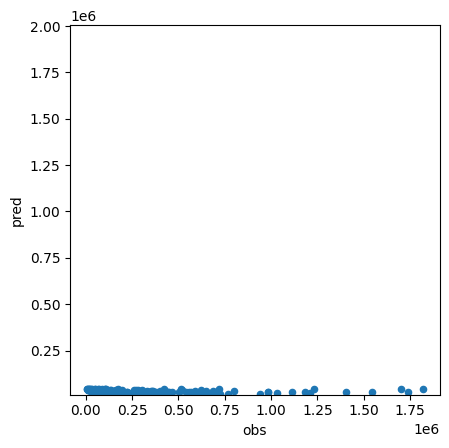

In [22]:
results.plot.scatter('obs','pred')
plt.gca().axis('square')
plt.show()